# Analyse IMDB Movie Data for Title Segmentation & Reccomendation
[Cloud Guru Challenge - October 2020](https://theclouddevopslearningblog.com/aws/sagemaker/2020/11/05/cloud-guru-challenge-2.html)

## Introduction
This notebook performs steps 2-5 of October Cloud Guru Challenge as listed here: https://acloudguru.com/blog/engineering/cloudguruchallenge-machine-learning-on-aws

The data used is the IMDB datasets. These can be accessed here: https://datasets.imdbws.com/

Some of the primary libraries used:
* Pandas library for loading and transforming the data (including one-hot-encoding descriptive attributes)
* Sklearn library for scaling and pre-training preparation
* AWS Sagemaker - PCA (for dimension reduction) and KMeans (for k-means cluster analysis)
* MatPlotLib and Seaborn for plotting and exploratory data analysis

Analysis steps based on the following AWS blog:
https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/

## Dependencies
Some libraries may need to be installed before using

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sagemaker

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mxnet

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import io
import gzip
import mxnet as mx
import os
import boto3
import sagemaker

from sklearn.preprocessing import MinMaxScaler
from sagemaker import get_execution_role
from sagemaker import PCA
from sagemaker import KMeans

%matplotlib inline
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

## Data Loading
Load the basic title info, alternate title info and title rating info into data frames

In [6]:
def remoteImdbToDf(dataset):
    url="https://datasets.imdbws.com/" + dataset + ".tsv.gz"
    content=requests.get(url).content
    open(dataset + '.tsv.gz', 'wb').write(content)
    
    with gzip.open(dataset + '.tsv.gz', 'rb') as read_file:
        file_content = read_file.read()
        write_file = open(dataset + '.tsv', 'wb')
        write_file.write(file_content)
        write_file.close()
    
    return pd.read_csv(dataset + '.tsv', sep='\t')
    

In [7]:
df_titleakas = remoteImdbToDf('title.akas')

In [8]:
df_titlebasics = remoteImdbToDf('title.basics')

In [9]:
df_titleratings = remoteImdbToDf('title.ratings')

## Exploratory data analysis EDA – Data cleaning and exploration

In [10]:
df_titlebasics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344891 entries, 0 to 7344890
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 504.3+ MB


In [11]:
# make the column names lower case to make it easier to work with
df_titlebasics.columns = ['titleid','type','title','originaltitle','isadult','startyear','endyear','length','genres']

In [12]:
df_titlebasics.head()

,titleid,type,title,originaltitle,isadult,startyear,endyear,length,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [13]:
# we're probably only going to want titles that are movies for the recommendation, let's check this field does that
df_titlebasics[df_titlebasics['type']=='movie'].sample(5)

,titleid,type,title,originaltitle,isadult,startyear,endyear,length,genres
5557554,tt6086042,movie,Warhol,Warhol,0,\N,\N,\N,"Biography,Drama"
220894,tt0230329,movie,The Pretty Indian Girl,La India bonita,0,1938,\N,64,Drama
1212472,tt10427928,movie,Chokher Bali,Chokher Bali,0,2020,\N,\N,Drama
62099,tt0063331,movie,"My Third Wife, George","My Third Wife, George",0,1968,\N,66,Comedy
7031704,tt9257646,movie,Good Bad Guys,Good Bad Guys,0,\N,\N,\N,Drama


In [14]:
# make the column names lower case to make it easier to work with
df_titleakas.columns = ['titleid','ordering','title','region','language','types','attributes','isoriginaltitle']

In [15]:
df_titleakas.sample(5)

,titleid,ordering,title,region,language,types,attributes,isoriginaltitle
18716907,tt6533854,3,エピソード #1.26,JP,ja,\N,\N,0
8306745,tt12500252,2,एपिसोड #1.1957,IN,hi,\N,\N,0
7710896,tt12206804,6,Épisode #10.27,FR,fr,\N,\N,0
13149273,tt2301900,1,Puppet Master: Axis Rising,US,\N,\N,short title,0
12091902,tt1947488,1,Le parfait amour,FR,\N,\N,\N,0


In [16]:
# merge the basic and alternate info data frames on the title id field
df_titlesfull = pd.merge(left=df_titlebasics, right=df_titleakas, left_on='titleid', right_on='titleid')

In [17]:
# we don't need this data anymore, all required info is in the new data frame
del df_titlebasics
del df_titleakas

In [18]:
df_titlesfull.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5,Карменсита,RU,\N,imdbDisplay,\N,0
5,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",6,Carmencita,US,\N,\N,\N,0
6,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",7,Carmencita,\N,\N,original,\N,1
7,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",8,カルメンチータ,JP,ja,imdbDisplay,\N,0
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1
9,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0


In [19]:
df_titleratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091118 entries, 0 to 1091117
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1091118 non-null  object 
 1   averageRating  1091118 non-null  float64
 2   numVotes       1091118 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 25.0+ MB


In [20]:
# make the column names lower case to make it easier to work with
df_titleratings.columns = ['titleid', 'averagerating', 'numvotes']

(array([  3815.,   8214.,  18320.,  38971.,  86968., 171851., 280532.,
        298374., 150510.,  33563.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

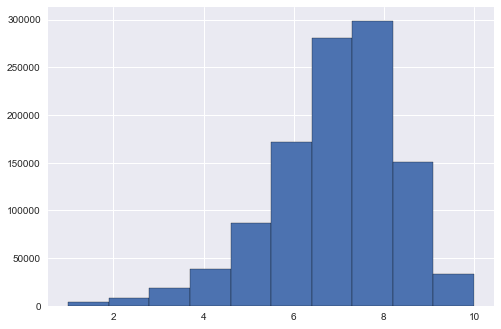

In [21]:
# let's check out the frequency of each rating
plt.hist(df_titleratings['averagerating'], edgecolor='black')

In [22]:
df_titleratings.sample(5)

,titleid,averagerating,numvotes
105267,tt0152218,6.0,93
1025891,tt7900186,4.5,6
665856,tt1933296,6.7,6
964124,tt6480098,7.9,49
882019,tt5023872,7.2,11


In [23]:
# merge the title info and ratings data frames on the title id field
df_titles = pd.merge(left=df_titlesfull, right=df_titleratings, left_on='titleid', right_on='titleid')

In [24]:
# we don't need this data anymore, all required info is in the new data frame
del df_titleratings
del df_titlesfull

In [25]:
df_titles.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0,5.6,1660
1,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",2,Carmencita,DE,\N,\N,literal title,0,5.6,1660
2,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0,5.6,1660
3,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0,5.6,1660
4,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5,Карменсита,RU,\N,imdbDisplay,\N,0,5.6,1660
5,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",6,Carmencita,US,\N,\N,\N,0,5.6,1660
6,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",7,Carmencita,\N,\N,original,\N,1,5.6,1660
7,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",8,カルメンチータ,JP,ja,imdbDisplay,\N,0,5.6,1660
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1,6.1,203
9,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0,6.1,203


In [26]:
df_titles.shape

(2993269, 18)

In [27]:
# the titles get duplicated if it's moved language/region, etc. Let's only consider original titles to remove bias
df_titles = df_titles.drop_duplicates(subset=['titleid'])

In [28]:
df_titles.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0,5.6,1660
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1,6.1,203
16,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",1,Sarmanul Pierrot,RO,\N,imdbDisplay,\N,0,6.5,1373
25,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",1,Un bon bock,\N,\N,original,\N,1,6.2,123
33,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",10,Blacksmith Scene,\N,\N,original,\N,1,6.2,2161
44,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short,1,Китайский опиумный притон,RU,\N,imdbDisplay,\N,0,5.3,116
50,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport",1,Corbett and Courtney Before the Kinetograph,US,\N,\N,\N,0,5.4,663
59,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short",10,Edison kinetoskopische Aufnahme eines Niesens,DE,\N,\N,literal title,0,5.4,1829
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
73,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",10,Радници напуштају фабрику Лимијер,RS,\N,imdbDisplay,\N,0,6.9,6087


In [29]:
df_titles.shape

(815709, 18)

In [30]:
# now let's get only movies
df_titles = df_titles[df_titles['type']=='movie']

In [31]:
df_titles.shape

(254954, 18)

In [32]:
df_titles.head()

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
999,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",1,Early Christian Martyrs,AU,\N,working,\N,0,6.0,39
1407,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,1,Bohemios,ES,\N,\N,\N,0,4.7,7
1546,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",1,Kelly bandájának története,HU,\N,imdbDisplay,\N,0,6.1,597
1635,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,1,Robbery Under Arms,AU,\N,\N,\N,0,4.5,14


In [33]:
#df_title = df_titles[df_titles['isoriginaltitle'] == 1]

In [34]:
#df_titles.head()

In [35]:
# let's drop some of the columns that won't contribute much to the clustering
#  (reconsider region later if needed, obviously need to one-hot-encode it and remove \N values)
df_titles.drop(['originaltitle','ordering','title_y','type',
                'types','region','types','attributes',
                'isoriginaltitle','endyear'],axis=1,inplace=True)

In [36]:
df_titles.shape

(254954, 9)

In [37]:
df_titles.head()

,titleid,title_x,isadult,startyear,length,genres,language,averagerating,numvotes
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155
999,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.0,39
1407,tt0000502,Bohemios,0,1905,100,\N,\N,4.7,7
1546,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,597
1635,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14


In [38]:
# make the column names lower case to make it easier to work with, rename some columns due to merge naming
df_titles.columns = ['titleid', 'title', 'isadult',
                     'year','length','genres',
                     'language','averagerating',
                     'numvotes']

In [39]:
df_titles.head()

,titleid,title,isadult,year,length,genres,language,averagerating,numvotes
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155
999,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.0,39
1407,tt0000502,Bohemios,0,1905,100,\N,\N,4.7,7
1546,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,597
1635,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14


In [40]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254954 entries, 69 to 2993246
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   titleid        254954 non-null  object 
 1   title          254954 non-null  object 
 2   isadult        254954 non-null  int64  
 3   year           254954 non-null  object 
 4   length         254954 non-null  object 
 5   genres         254954 non-null  object 
 6   language       254954 non-null  object 
 7   averagerating  254954 non-null  float64
 8   numvotes       254954 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 19.5+ MB


In [41]:
# let's not consider any titles that don't have a valid year value
df_titles = df_titles[(df_titles['year']!='\\N')]

In [42]:
#  convert the year value (string) to integer for easy scaling and comparison
df_titles['year'] = df_titles['year'].astype(int)

<BarContainer object of 126 artists>

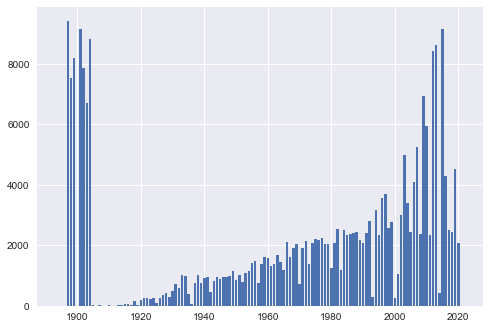

In [43]:
# let's check how many titles are there for each year
plt.bar(df_titles.year.unique(),
        df_titles.year.value_counts().sort_index())

Text(0, 0.5, 'average rating of movie')

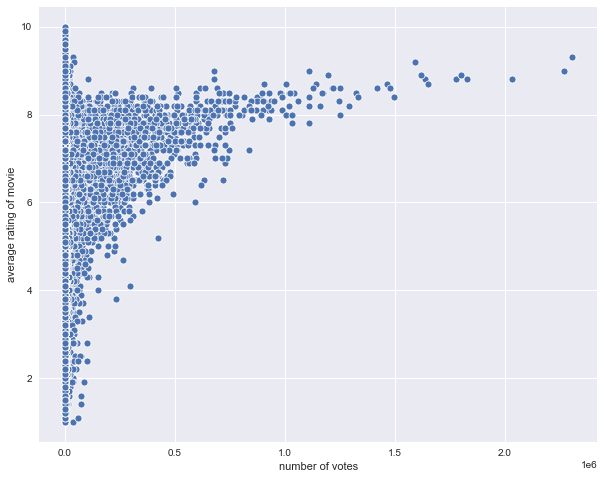

In [44]:
# and check out if there's a relationship between number of votes and the average rating
plt.figure(figsize = (10,8))
sns.scatterplot(x = df_titles['numvotes'], y = df_titles['averagerating'])
plt.xlabel('number of votes')
plt.ylabel('average rating of movie')

Text(0.5, 0, 'year')

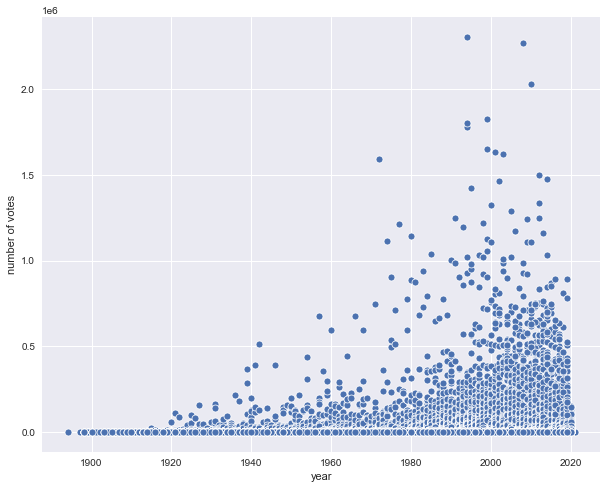

In [45]:
# plot number of votes per movie based on year of release
plt.figure(figsize = (10,8))
sns.scatterplot(x = df_titles['year'], y = df_titles['numvotes'])
plt.ylabel('number of votes')
plt.xlabel('year')

## Data modelling

The 'genres' column contains non-numerical comma-separated-values for zero, one or multiple genres for the title. To make this value comparible (and useful for clustering), this needs to be made into a numerical (0 or 1) for each value. To do this, we need to use a process called 'one-hot-encoding' 

In [46]:
# we can see there's lots of unique values, as each genre can be combined with others
df_titles.genres.unique()

array(['Romance', 'Biography,Drama', '\\N', ..., 'Fantasy,History,War',
       'Documentary,Family,Sci-Fi', 'Horror,Musical,Thriller'],
      dtype=object)

In [47]:
df_titles.genres.unique().shape

(1255,)

In [48]:
df_titles.shape

(254935, 9)

In [49]:
# let's convert the csv column to a pandas list object in a new column
df_titles['genres_list'] = df_titles.genres.str.split(',').tolist()
df_titles.head()

,titleid,title,isadult,year,length,genres,language,averagerating,numvotes,genres_list
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155,[Romance]
999,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.0,39,"[Biography, Drama]"
1407,tt0000502,Bohemios,0,1905,100,\N,\N,4.7,7,[\N]
1546,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,597,"[Biography, Crime, Drama]"
1635,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14,[Drama]


In [50]:
df_titles.shape

(254935, 10)

In [51]:
# get the one hot encoded values for genre. 
# (this table is relatively sparse)
genres_one_hot_encoded = df_titles.genres_list.str.join('|').str.get_dummies().add_prefix('genre_')

In [52]:
genres_one_hot_encoded.head()

,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western,genre_\N
69,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
999,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1546,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1635,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
genres_one_hot_encoded.shape

(254935, 29)

In [54]:
# let's add these new columns to the original full data
df_titles = pd.concat([df_titles, genres_one_hot_encoded], axis=1, sort=False)

In [55]:
# get the one hot encoded values for language. 
language_one_hot_encoded = pd.get_dummies(df_titles.language, prefix='language')
language_one_hot_encoded.head()

,language_\N,language_af,language_ar,language_az,language_bg,language_bn,language_bs,language_ca,language_cmn,language_cs,...,language_te,language_th,language_tl,language_tr,language_uk,language_ur,language_yi,language_yue,language_zh,language_zu
69,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1407,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1546,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1635,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# let's add these new columns to the original full data
df_titles = pd.concat([df_titles, language_one_hot_encoded], axis=1, sort=False)

In [57]:
# now we can drop the descriptive value columns, and the one-hot-encoded columns for null values
df_titles.drop(['genres','language','genres_list','genre_\\N','language_\\N'],axis=1,inplace=True)

In [58]:
df_titles.titleid.unique().shape

(254935,)

In [59]:
df_titles.titleid.shape

(254935,)

In [60]:
df_titles.title.unique().shape

(228233,)

In [61]:
df_titles.title.shape

(254935,)

In [62]:
# We can now set the ‘titleid and title’ 
#   as the index and the rest of the numerical 
#   features become the attributes of each unique title.
df_titles.index=df_titles['titleid'] + " " + df_titles['title']
df_titles.drop(['titleid','title'],axis=1,inplace=True)

In [63]:
# Let's get rid of titles where the length value isn't available
df_titles = df_titles[df_titles['length'] != '\\N']

# and conver the length to integer for scale/comparison ease
df_titles['length'] = df_titles['length'].astype(int)

In [64]:
# Remove some really short/long titles, lowly rated, and old movies
df_titles = df_titles[
    (df_titles['length'] > 30) & 
    (df_titles['length'] < 360) &  
    (df_titles['numvotes'] > 5000) &
    (df_titles['year'] > 1960) &
    (df_titles['averagerating'] > 3.0)
]

In [65]:
df_titles.shape

(12162, 96)

### Feature engineering

In [66]:
# Data Scaling – We need to standardize the scaling of the numerical columns 
#   in order to use any distance based analytical methods so that we can 
#   compare the relative distances between different feature columns. We can 
#   use minmaxscaler to transform the numerical columns so that they also 
#   fall between 0 and 1.
scaler=MinMaxScaler()
df_titles_scaled=pd.DataFrame(scaler.fit_transform(df_titles))
df_titles_scaled.columns=df_titles.columns
df_titles_scaled.index=df_titles.index

In [67]:
df_titles_scaled.describe()

,isadult,year,length,averagerating,numvotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,...,language_te,language_th,language_tl,language_tr,language_uk,language_ur,language_yi,language_yue,language_zh,language_zu
count,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,...,12162.000000,12162.000000,12162.000000,12162.000000,12162.0,12162.000000,12162.0,12162.000000,12162.0,12162.0
mean,0.000082,0.700969,0.208625,0.560388,0.024694,0.231623,0.000082,0.148166,0.042592,0.068410,...,0.000904,0.000329,0.000082,0.021543,0.0,0.000082,0.0,0.001151,0.0,0.0
std,0.009068,0.235406,0.069571,0.155801,0.057118,0.421887,0.009068,0.355279,0.201943,0.252458,...,0.030062,0.018133,0.009068,0.145190,0.0,0.009068,0.0,0.033910,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,0.000000,0.576271,0.160656,0.467742,0.001501,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
50%,0.000000,0.762712,0.193443,0.564516,0.005654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
75%,0.000000,0.881356,0.239344,0.677419,0.021369,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0


In [68]:
df_titles_scaled.shape

(12162, 96)

In [69]:
# Get the current service/execution role (ensure it has Sagemaker execute permissions)
try:
    role = get_execution_role()
except:
    role = 'arn:aws:iam::955966247963:role/service-role/AmazonSageMaker-ExecutionRole-20201024T195844'

Couldn't call 'get_role' to get Role ARN from role name simon3 to get Role path.


In [70]:
role

'arn:aws:iam::955966247963:role/service-role/AmazonSageMaker-ExecutionRole-20201024T195844'

In [71]:
bucket_name='movies-bucket-s3bucket-1la82ft02b7le'

In [72]:
num_components=95

pca_SM = PCA(role=role,
          instance_count=1,
          instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/titles/',
            num_components=num_components)

In [73]:
#convert the numerical values to 32 bit floats for consistancy
train_data = df_titles_scaled.values.astype('float32')

In [74]:
%%time
# We call the fit function on our PCA model, passing in our training data, 
# and this spins up a training instance or cluster to perform the training job.
pca_SM.fit(pca_SM.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-17 10:13:47 Starting - Starting the training job...
2020-11-17 10:13:49 Starting - Launching requested ML instances......
2020-11-17 10:14:55 Starting - Preparing the instances for training......
2020-11-17 10:16:17 Downloading - Downloading input data...
2020-11-17 10:16:34 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/17/2020 10:16:57 INFO 140595895781184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[11/17/2020 10:16:57 INFO 140595895781184] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'96', u'mini_batch_size': u'500', u'num_compo


2020-11-17 10:17:06 Uploading - Uploading generated training model
2020-11-17 10:17:06 Completed - Training job completed
Training seconds: 49
Billable seconds: 49
CPU times: user 1.06 s, sys: 162 ms, total: 1.22 s
Wall time: 3min 50s


In [75]:
job_name=pca_SM._current_job_name
job_name

'pca-2020-11-17-10-13-47-320'

In [76]:
# Get the model artifacts from S3 after they have been trained
model_key = "titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [77]:
# load the ND array using MXNet
pca_model_params = mx.ndarray.load('model_algo-1')

In [78]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [79]:
#We can now calculate the variance explained by the largest n components that we want to keep. 
# For this example, let's take the top 20 components.
#We can see that the largest 20 components explain ~91% of the total variance in our dataset:
s.iloc[75:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.912749
dtype: float32

In [80]:
s_20=s.iloc[75:,:]
v_20=v.iloc[:,75:]
v_20.columns=[0,1,2,3,4,5,6,7,8,
              9,10,11,12,13,14,
              15,16,17,18,19]

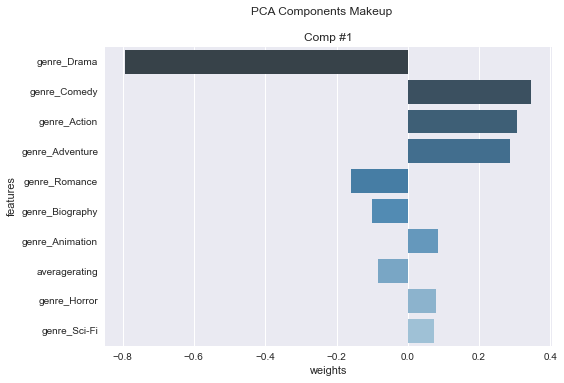

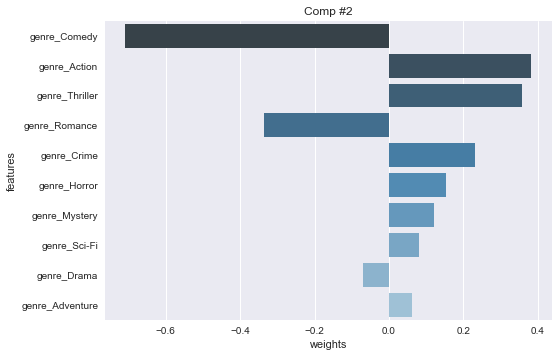

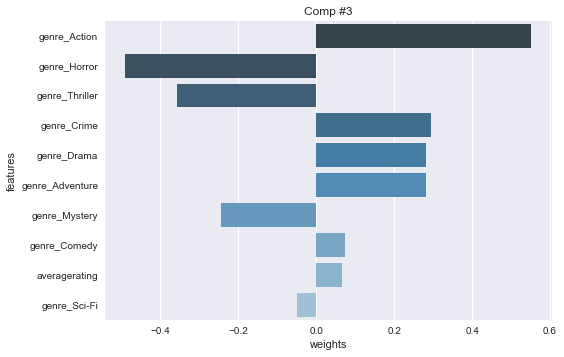

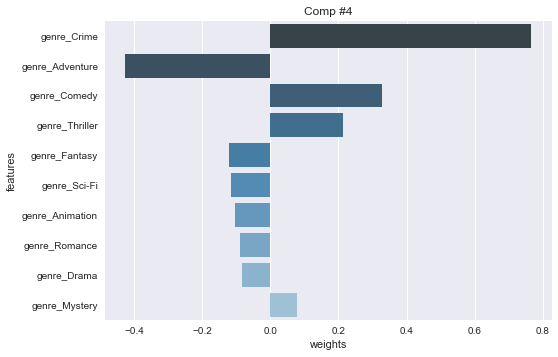

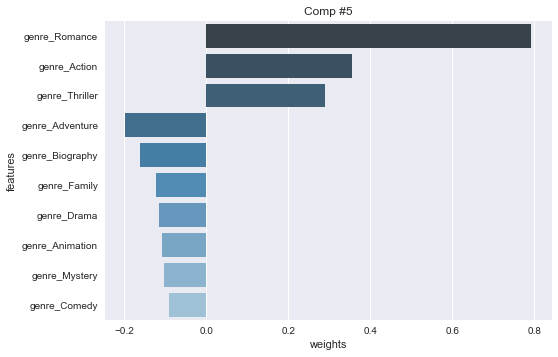

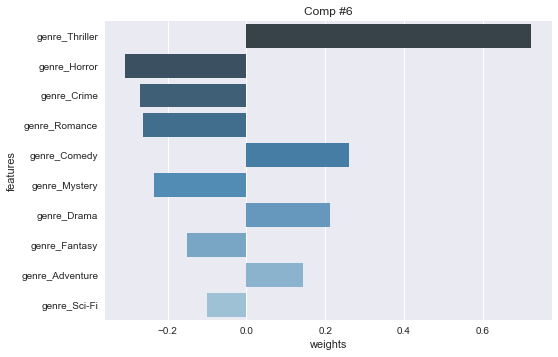

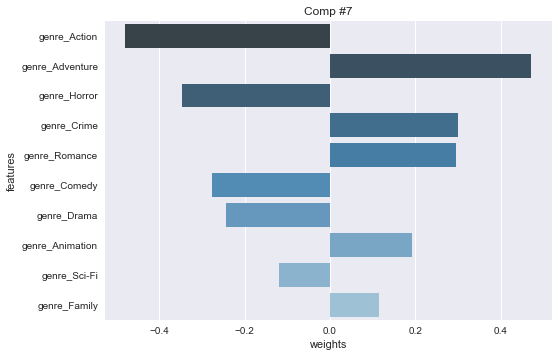

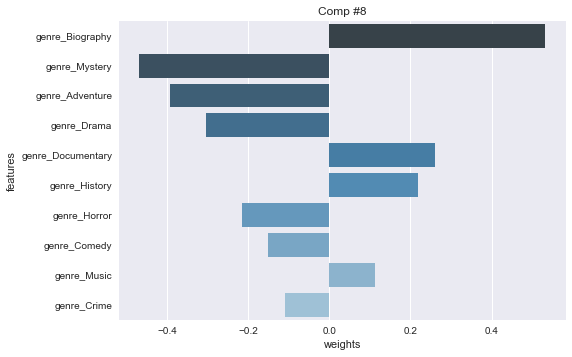

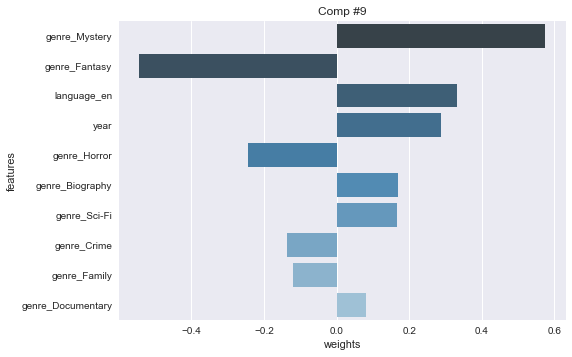

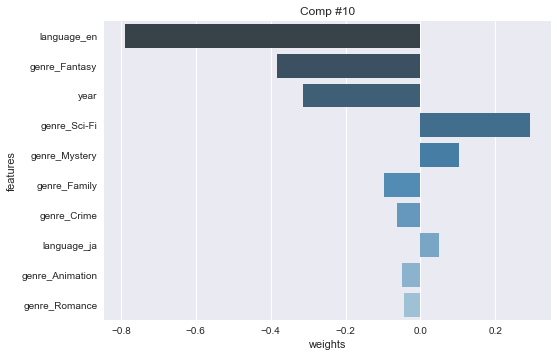

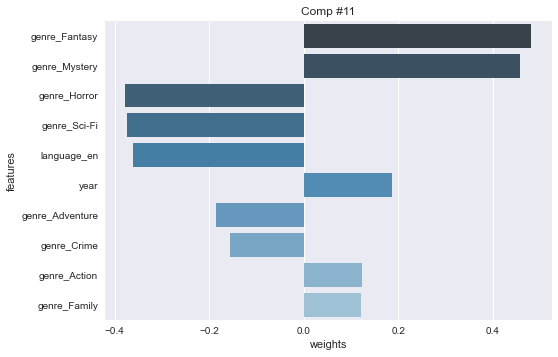

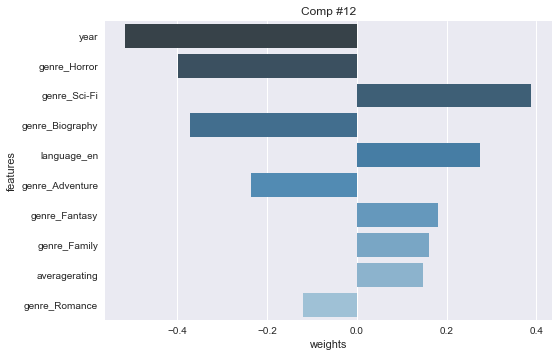

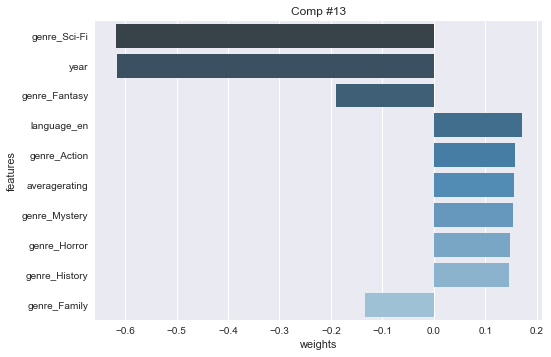

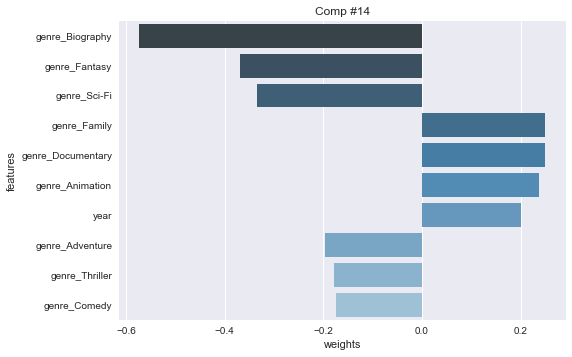

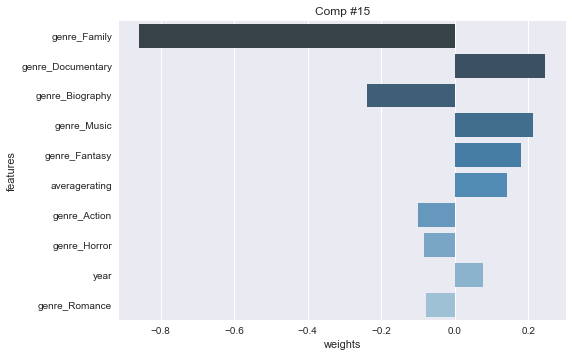

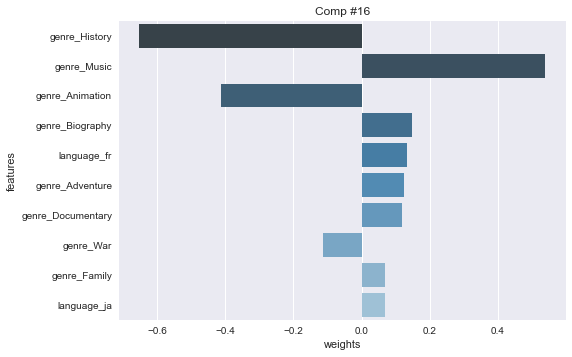

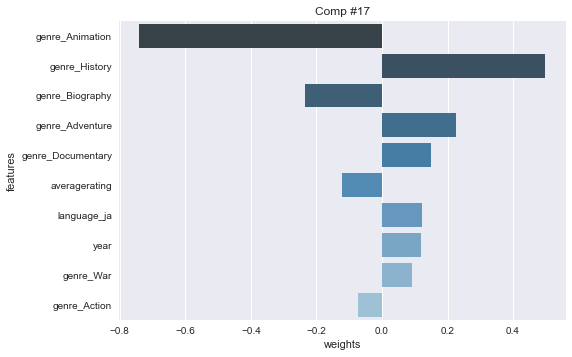

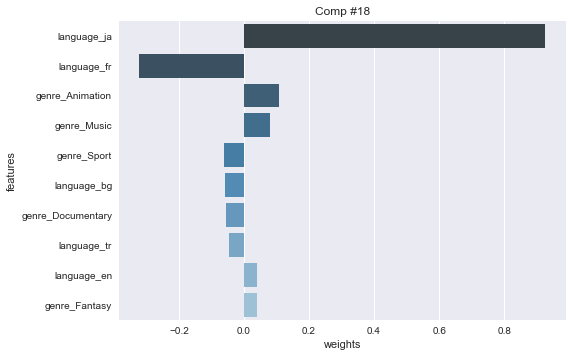

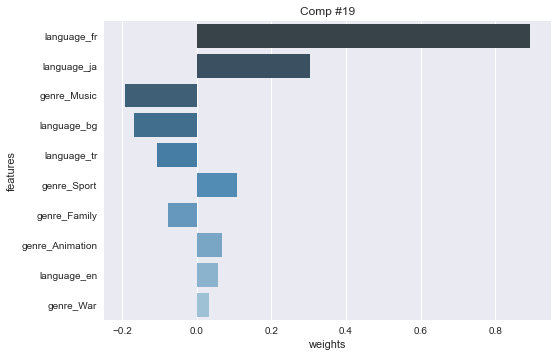

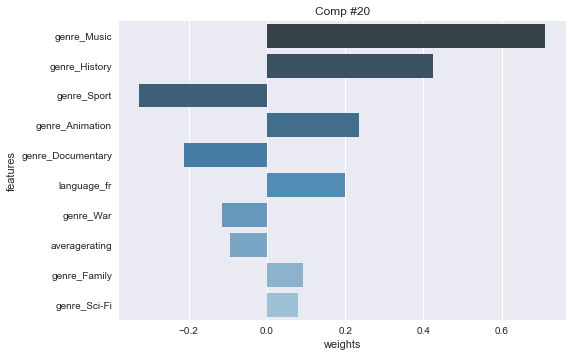

In [81]:
with plt.style.context('seaborn'):
    plt.suptitle('PCA Components Makeup')
    component_num = 1
    for i in range(5):
        for j in range(4):
            comps = pd.DataFrame(list(zip(v_20[20 - component_num], df_titles_scaled.columns)), columns=['weights', 'features'])
            comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
            axes = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
            axes.set_title("Comp #"+str(component_num))
            component_num += 1
            plt.show() 
          

In [82]:
#Will need to review this as the data will change over time
PCA_list=['Comedy/Action/Adventure', 'Crime/Action/Thriller', 'Action/Crime', 'Crime/Comedy',
          'Action/Romance', 'Thriller/Comedy', 'Adventure/Crime', 'Bio/Doco', 'Mystery/EN-Lang/Recent',
          'Non-EN-Lang/Older/Sci-Fi', 'Mystery/Fantasy', 'Older/Sci-Fi', 'Older', 
          'Family/Doco/Animation', 'Doco/Music', 'Music', 'History',
          'JA-Lang', 'FR-Lang', 'Music/History']

In [83]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 424 ms, sys: 52.6 ms, total: 476 ms
Wall time: 8min 36s


In [84]:
%%time
result = pca_predictor.predict(train_data)
df_titles_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    df_titles_transformed=df_titles_transformed.append([list(b)])
df_titles_transformed.index=df_titles_scaled.index
df_titles_transformed=df_titles_transformed.iloc[:,75:]
df_titles_transformed.columns=PCA_list

CPU times: user 59.2 s, sys: 7.92 s, total: 1min 7s
Wall time: 1min 13s


In [85]:
df_titles_transformed.head()

,Comedy/Action/Adventure,Crime/Action/Thriller,Action/Crime,Crime/Comedy,Action/Romance,Thriller/Comedy,Adventure/Crime,Bio/Doco,Mystery/EN-Lang/Recent,Non-EN-Lang/Older/Sci-Fi,Mystery/Fantasy,Older/Sci-Fi,Older,Family/Doco/Animation,Doco/Music,Music,History,JA-Lang,FR-Lang,Music/History
tt0035423 Kate & Leopold,0.028802,-0.012274,0.017747,-0.046469,-0.091801,0.188921,-0.385192,-0.139496,0.147585,0.517406,-0.343527,-0.489214,0.039945,0.136033,-0.331732,0.554016,-0.015796,-0.258909,-0.926008,0.470016
tt0052646 The Brain That Wouldn't Die,0.058413,-0.007547,0.003720,-0.075514,-0.010672,-0.102776,-0.208210,-0.119316,0.462000,-0.794361,0.503382,-0.266083,0.088591,-0.245480,-0.623626,-0.115356,-0.284708,-0.831760,0.335616,0.414407
tt0053987 The Steamroller and the Violin,-0.085183,-0.012457,-0.011848,-0.117744,0.037008,0.030331,0.065433,0.396366,0.466773,-0.129914,0.292797,-0.256598,0.034346,0.017349,0.002217,-0.225414,-0.211314,0.014586,0.026587,-0.563831
tt0054130 La Notte,-0.096977,-0.015982,-0.009508,-0.120005,0.029983,0.046877,0.059682,0.421724,0.488143,-0.128681,0.297872,-0.251784,0.049840,0.025670,0.006601,-0.229462,-0.217664,0.031537,0.028868,-0.580866
tt0054177 Le Petit Soldat,-0.198858,0.019289,-0.029851,-0.010878,-0.077978,0.095457,0.161045,0.446674,0.520306,-0.129278,0.295113,-0.247282,0.072498,-0.000929,0.014533,-0.230075,-0.242650,0.026045,0.031583,-0.590686


In [86]:
train_data = df_titles_transformed.values.astype('float32')

In [87]:
#If the number of clusters is high, hopefully we get better recommendations
num_clusters = 40
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/titles/',              
                k=num_clusters)

In [88]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-17 10:27:31 Starting - Starting the training job...
2020-11-17 10:27:35 Starting - Launching requested ML instances......
2020-11-17 10:28:58 Starting - Preparing the instances for training......
2020-11-17 10:29:55 Downloading - Downloading input data...
2020-11-17 10:30:35 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/17/2020 10:30:38 INFO 140284064712512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_cen


2020-11-17 10:30:48 Uploading - Uploading generated training model
2020-11-17 10:30:48 Completed - Training job completed
Training seconds: 53
Billable seconds: 53
CPU times: user 884 ms, sys: 95 ms, total: 979 ms
Wall time: 3min 48s


In [89]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 418 ms, sys: 52.8 ms, total: 470 ms
Wall time: 8min 36s


In [90]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 660 ms, sys: 40.2 ms, total: 700 ms
Wall time: 6.88 s


In [91]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

1.0     992
9.0     849
6.0     726
8.0     640
3.0     596
10.0    540
14.0    442
22.0    428
20.0    422
11.0    387
17.0    374
5.0     374
12.0    339
21.0    315
38.0    277
4.0     273
26.0    251
2.0     227
18.0    213
13.0    213
25.0    209
34.0    209
16.0    208
15.0    200
23.0    192
7.0     190
27.0    184
29.0    183
37.0    183
39.0    175
24.0    166
30.0    165
32.0    153
33.0    148
35.0    145
36.0    142
31.0    139
19.0    136
28.0    104
0.0      53
Name: 0, dtype: int64

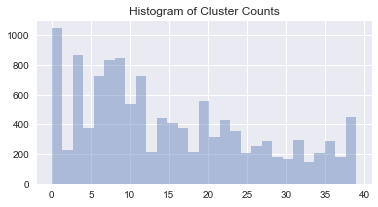

In [92]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

## Drawing conclusions from our modelling

In [93]:
#job_name='<your_SageMaker_KMeans_job_name_here>'
job_name=kmeans._current_job_name

model_key = "titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [94]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=df_titles_transformed.columns
cluster_centroids

,Comedy/Action/Adventure,Crime/Action/Thriller,Action/Crime,Crime/Comedy,Action/Romance,Thriller/Comedy,Adventure/Crime,Bio/Doco,Mystery/EN-Lang/Recent,Non-EN-Lang/Older/Sci-Fi,Mystery/Fantasy,Older/Sci-Fi,Older,Family/Doco/Animation,Doco/Music,Music,History,JA-Lang,FR-Lang,Music/History
0,-0.023970,0.001820,-0.011077,0.223252,0.113179,0.037499,-0.011320,0.048737,-0.213066,-0.150030,-0.030735,-0.064856,-0.198245,0.468065,-0.322262,0.008274,0.139061,0.857924,0.800471,0.783452
1,-0.024171,-0.001756,0.000479,0.042416,-0.031247,0.058498,0.171880,-0.012555,0.156529,0.014054,0.068879,-0.097447,0.063830,-0.009849,0.048878,-0.228431,-0.275937,0.038366,0.064154,-0.551231
2,0.081997,-0.061827,0.036300,-0.021290,0.006937,-0.726804,0.223165,-0.137581,0.286166,0.288191,-0.113856,-0.222685,0.106022,0.039716,0.053925,-0.233603,0.080671,-0.125317,-0.618561,0.539973
3,-0.001325,0.020564,0.011646,-0.002393,-0.009889,-0.016072,-0.068287,0.010501,-0.110258,-0.051690,0.017768,0.009641,-0.180884,-0.035888,0.031487,0.515028,0.021302,0.055948,-0.990224,-0.370865
4,-0.018306,-0.007853,-0.006332,-0.003675,0.003076,0.008214,0.073406,0.100461,-0.104062,-0.285237,-0.023028,-0.337423,0.042112,-0.226611,-0.533168,-0.097841,-0.276822,-0.592584,0.389891,0.449022
5,-0.004774,-0.001925,-0.001969,-0.028973,0.027235,-0.024502,-0.025657,0.066579,0.056748,0.159309,0.018241,0.057618,0.097053,-0.173762,0.580068,0.514724,-0.099073,0.028436,0.852399,0.422182
6,0.026439,-0.010440,-0.002584,-0.001218,0.003598,0.005091,0.061673,-0.008814,0.009088,0.011710,0.019597,-0.052788,-0.059842,0.242910,-0.212398,0.610949,-0.317684,-0.032643,-0.235105,-0.699963
7,-0.009588,-0.004127,0.011920,-0.073293,-0.017816,0.001291,0.006884,0.119931,0.024466,0.251053,0.014258,0.059188,0.086941,-0.588251,0.033510,0.242968,0.067516,0.394406,-0.228330,0.722401
8,-0.041164,0.007238,-0.023639,0.013500,-0.004976,0.077971,0.008832,-0.022290,0.166755,-0.000342,0.036691,0.089578,0.184973,-0.115597,0.069558,-0.172664,0.159772,-0.205881,-0.557964,0.568565
9,0.008098,-0.010999,0.016639,0.009752,0.040262,0.059803,0.004429,-0.037262,0.020097,0.029794,0.066376,-0.016853,-0.108138,-0.299982,0.289830,-0.309325,0.067411,0.104695,-0.651108,-0.190997


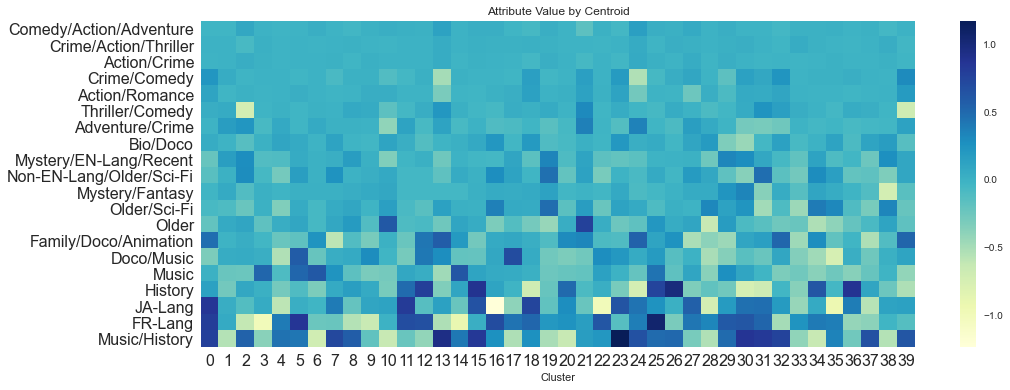

In [95]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [96]:
df_titles_transformed['labels']=list(map(int, cluster_labels))
df_titles_transformed.head()

,Comedy/Action/Adventure,Crime/Action/Thriller,Action/Crime,Crime/Comedy,Action/Romance,Thriller/Comedy,Adventure/Crime,Bio/Doco,Mystery/EN-Lang/Recent,Non-EN-Lang/Older/Sci-Fi,...,Older/Sci-Fi,Older,Family/Doco/Animation,Doco/Music,Music,History,JA-Lang,FR-Lang,Music/History,labels
tt0035423 Kate & Leopold,0.028802,-0.012274,0.017747,-0.046469,-0.091801,0.188921,-0.385192,-0.139496,0.147585,0.517406,...,-0.489214,0.039945,0.136033,-0.331732,0.554016,-0.015796,-0.258909,-0.926008,0.470016,14
tt0052646 The Brain That Wouldn't Die,0.058413,-0.007547,0.003720,-0.075514,-0.010672,-0.102776,-0.208210,-0.119316,0.462000,-0.794361,...,-0.266083,0.088591,-0.245480,-0.623626,-0.115356,-0.284708,-0.831760,0.335616,0.414407,4
tt0053987 The Steamroller and the Violin,-0.085183,-0.012457,-0.011848,-0.117744,0.037008,0.030331,0.065433,0.396366,0.466773,-0.129914,...,-0.256598,0.034346,0.017349,0.002217,-0.225414,-0.211314,0.014586,0.026587,-0.563831,1
tt0054130 La Notte,-0.096977,-0.015982,-0.009508,-0.120005,0.029983,0.046877,0.059682,0.421724,0.488143,-0.128681,...,-0.251784,0.049840,0.025670,0.006601,-0.229462,-0.217664,0.031537,0.028868,-0.580866,1
tt0054177 Le Petit Soldat,-0.198858,0.019289,-0.029851,-0.010878,-0.077978,0.095457,0.161045,0.446674,0.520306,-0.129278,...,-0.247282,0.072498,-0.000929,0.014533,-0.230075,-0.242650,0.026045,0.031583,-0.590686,1


In [97]:
cluster=df_titles_transformed[df_titles_transformed['labels']==20]
cluster.sample(10)

,Comedy/Action/Adventure,Crime/Action/Thriller,Action/Crime,Crime/Comedy,Action/Romance,Thriller/Comedy,Adventure/Crime,Bio/Doco,Mystery/EN-Lang/Recent,Non-EN-Lang/Older/Sci-Fi,...,Older/Sci-Fi,Older,Family/Doco/Animation,Doco/Music,Music,History,JA-Lang,FR-Lang,Music/History,labels
tt0418110 Romanzo Criminale,-0.054034,-0.034623,-0.032992,0.025997,-0.021354,0.069982,0.127503,-0.160262,0.003789,-0.141928,...,-0.174093,-0.046491,0.247095,-0.229549,-0.275956,0.543711,0.322826,0.285067,-0.620523,20
tt1014763 Child 44,0.373363,-0.017647,-0.020262,0.555626,-0.676157,0.066508,0.082108,-0.138202,-0.144937,-0.086015,...,-0.074578,0.165722,0.218423,-0.222707,-0.328748,0.486676,0.336099,0.305022,-0.668223,20
tt0116767 Kids Return,-0.377353,0.077825,-0.089840,-0.026783,0.048801,0.050258,0.157245,-0.050448,0.109242,-0.157320,...,-0.198317,0.029110,0.260524,-0.238696,-0.308268,0.532921,0.320731,0.267637,-0.628313,20
tt0427969 Hollywoodland,-0.058027,-0.033725,-0.010358,-0.196468,0.131300,-0.183719,-0.442423,-0.075241,-0.394045,-0.080485,...,-0.004011,0.474492,0.301032,-0.296346,-0.431334,0.491631,0.360176,0.300878,-0.709541,20
tt1734110 No One Killed Jessica,-0.071905,-0.036837,-0.011595,-0.198656,0.120910,-0.161189,-0.423410,-0.108542,-0.420644,-0.065854,...,0.022747,0.488528,0.302364,-0.289844,-0.434637,0.488335,0.369135,0.302690,-0.721001,20
tt1152836 Public Enemies,-0.068771,-0.036068,-0.011283,-0.199092,0.123894,-0.166775,-0.434546,-0.094642,-0.406273,-0.071527,...,0.013372,0.483835,0.304101,-0.291684,-0.434019,0.487254,0.368937,0.303462,-0.717285,20
tt0102307 Light Sleeper,-0.040311,-0.027307,-0.026664,-0.001499,-0.007069,0.045708,0.087340,-0.037394,0.107240,-0.184272,...,-0.240209,-0.061291,0.263546,-0.242241,-0.282917,0.549128,0.312569,0.276777,-0.609091,20
tt0099951 The Krays,-0.048893,-0.027012,-0.000969,-0.231964,0.144238,-0.202692,-0.495185,0.093069,-0.252652,-0.131841,...,-0.082309,0.466649,0.326726,-0.309106,-0.442650,0.494327,0.358534,0.291985,-0.706842,20
tt0075314 Taxi Driver,-0.054207,-0.023071,-0.015484,-0.061908,-0.006695,0.060974,0.028982,0.159480,0.284577,-0.237573,...,-0.311632,-0.050307,0.309730,-0.249399,-0.306668,0.541727,0.331868,0.270448,-0.623247,20
tt0070511 Papillon,-0.060047,-0.023060,0.012087,-0.288392,0.146015,-0.192126,-0.552953,0.308118,-0.068081,-0.187533,...,-0.159562,0.480560,0.371122,-0.317008,-0.465621,0.489653,0.377332,0.283321,-0.725645,20


In [98]:
# merge the title info and ratings data frames on the title id field
df_titles_clustered = pd.merge(left=df_titles, right=df_titles_transformed, left_index=True, right_index=True)

In [99]:
df_titles_clustered.to_csv("clustered_titles.csv")

In [100]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [101]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [102]:
boto3.resource('s3').Bucket(bucket_name).upload_file("clustered_titles.csv", "titles/clustered_titles.csv")